In [134]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time

## TESTING ONLY
import warnings
warnings.filterwarnings("ignore")

# IJS Implementation

In [135]:
# Full IJS usage

def poly_coeff_from_roots(roots):
    coeffs = []
    
    # Go through all the roots
    n = len(roots)
    #print(n)
    
    # Generate the result Polynomial, which initially is set to -roots[0] + x :: index of the list can be seen as power of x
    coeffs.insert(0, (-1)*roots[0])
    coeffs.insert(1,1)
    
    # Continue multiplying -roots[i] + x
    i = 1
    while i < n:
        # right shift, equivalent to multiplying x, the index increased 1 as the result
        coeffs.insert(0,0)        
        j = 0
        while j < (len(coeffs) - 1):
            # mu
            coeffs[j] = coeffs[j] + coeffs[j+1] * (-1) * roots[i]
            j = j + 1

        i = i + 1
    return coeffs[::-1]  ## reverse list from highest power coefficient to lowest

#print(poly_coeff_from_roots([1,2,3,4,5]))
##################################################################################################################
success_count = 0 ##################################################################################################################
step_count = 0    ##################################################################################################################
def get_coeff_list(c, w, t, v):
    """
    c - sent coeffs
    w - secondary list at second device

    s, n,
    s - size of w ##### ## b
    n - window size for root selection (not used -- same as s) #### number of roots to generate s-(t/2)

    v - number of varations of roots 
    ### IMPORTANT: CAN ONLY CORRECT ONE ERROR or t/2 errors
    """
    ##################
    s = len(w)
    n = s 
    #print(c, w, s, n, t, v)
    ##################

    result = [] # coefficients found
    corr_seq = []
    #print(c)
    # # For range finding on second device (not used if window is fixed or full)
    #for i in range(0, s-n+1, 1):
        #r_w = w[i: i+n] # values of w in the window - to find root of... (should be full - in algo.)
    ### Indent if using range -- till before return
    r_w = w.copy()
    #print(r_w)
    for err_idx in range(n):
        removed_r = r_w[err_idx]
        k = int(math.pow((2 * v + 1), (n-1)))
        #print(k)
        while k > 0:
            temp_list = r_w.copy()
            temp_list.remove(removed_r)
            temp_variation = k - 1

            for l in range(n-1):
                temp_list[l] = temp_list[l] + (temp_variation % (2 * v + 1)) - v
                temp_variation = temp_variation // (2 * v + 1)
            #print(temp_list)
            residue_coeff = poly_coeff_from_roots(temp_list)
            #print(residue_coeff)
            addd_rt = (-1) * (c[1] - residue_coeff[1])
            temp_list.insert(err_idx,addd_rt)
            residue_coeff = poly_coeff_from_roots(temp_list)
            #print(residue_coeff)
            k = k - 1
            if(residue_coeff not in result):
                #print(residue_coeff)
                coeff_check = True
                
                for i_t in range(len(c)-1): #+1 -1 # # t
                    if(c[i_t+1] != residue_coeff[i_t+1]): # or not coeff_check
                        coeff_check = False
                        break
                if(coeff_check):
                    corr_seq = temp_list
                    result.append(residue_coeff)
                # if(c[1] == residue_coeff[1] and c[2] == residue_coeff[2]):#  and c[3] == residue_coeff[3]):
                #     result.append(residue_coeff)
        ###
    # print("Corrected Sequence at Bob:", corr_seq)

    # ###############################################################################################################################
    # global success_count
    # global step_count
    # if(len(result)>1):
    #     print("Multiple Sequences")
    # else:
    #     success_count += 1 ######################################################################################################## 
    # step_count += 1
    # ###############################################################################################################################
    
    return result, corr_seq


___


# Cubic Spline Projection 

In [136]:
import numpy as np

# Cubic spline projection - 2 points at a time
def spline_projection(seq):
    projected_seq = []
    for i in range(1, len(seq)-1, 1):
        A = np.array(
            [[(i-1)**3,     (i-1)**2,   (i-1)**1,   1,  0,       0,      0,      0],
            [0,             0,          0,          0,  i**3,    i**2,   i**1,   1],
            [i**3,          i**2,       i**1,       1,  0,       0,      0,      0],
            [(i+1)**3,      (i+1)**2,   (i+1)**1,   1,  0,       0,      0,      0],
            [3*i**2,        2*i,        1,          0,  -3*i**2, -2*i,   -1,     0],
            [6*i,           2,          0,          0,  -6*i,    -2,     0,      0],
            [6*(i-1),       2,          0,          0,  0,       0,      0,      0],
            [0,             0,          0,          0,  6*(i+1), 2,      0,      0]]
        )
        b = np.array([seq[i-1], seq[i], seq[i], seq[i+1], 0, 0, 0, 0])
        coeff = np.dot(np.linalg.inv(A), b)
        
        #print(np.linalg.det(A))
        #print(np.dot(np.linalg.inv(A), b))
        #print(i)

        # projection Distance
        k = i+2

        # projected cubic eq.
        projected_seq.append( round(coeff[0]*k**3 + coeff[1]*k**2 + coeff[2]*k**1 + coeff[3]) )  ## first eq. 


        #projected_seq.append( round(coeff[4]*k**3 + coeff[5]*k**2 + coeff[6]*k**1 + coeff[7]) ) ## second eq.
    return projected_seq

# # TESTS
# print(spline_projection(alice))
# print()
# print(spline_projection(bob))

# Quantization


In [149]:
# Quantization - uniform
#d = [-94, -62, -32, -99, -34, -76, -34, -68]
global previous_lvls
previous_lvls = []
def quantization_m(data, m):
    global previous_lvls
    data = np.array(data)
    quant_seq = []

    ##########################################
    # ### NORMALIZATION
    # variance = (1/len(data)) * np.sum(data**2)
    # norm_x = data/np.sqrt(variance)
    # data_x = np.round(norm_x, 4)  ### FLOATING POINT ERROR OTHERWISE

    # x_min = min(data_x)
    # x_max = max(data_x)
    # #print(x_max)
    # delta = (x_max-x_min)/(m)
    # #print((x_min-(delta/100), x_max+(delta/100), delta), norm_x)
    ##########################################
    
    ### WITHOUT NORMALIZATION
    data_x = data

    x_min = min(data_x)
    x_max = max(data_x)
    #print(x_max)
    delta = (x_max-x_min)/(m)
    #print((x_min-(delta/100), x_max+(delta/100), delta), norm_x)


    try:
        lvls = np.round(np.arange(x_min, x_max+0.0002, delta), 4) # delta*0.01
        #  print(lvls)
        ## print(lvls, x_min, x_max)
        ## print(norm_x)
    except:
        lvls = previous_lvls # failsafe if quantization level gen. fails

    previous_lvls = lvls 

    for x in data_x:
        assign_check = True
        for i in range(1,len(lvls)):
            # print(x, lvls[i-1], lvls[i], lvls)
            if(x>=lvls[i-1] and x<=lvls[i]):
                #print(len(lvls))
                quant_seq.append(i) # to starting level no. --- set later -1
                #print(x, lvls[i-1], lvls[i], (x>=lvls[i-1] and x<=lvls[i]))
                #print(i)
                assign_check = False
                break
        # UN-needed
        # if(assign_check):
        #     #print(x, lvls[i-1], lvls[i], (x>=lvls[i-1] and x<=lvls[i]))
        #     quant_seq.append(-1)
    #print(quant_seq) 
    return quant_seq

#quantization_m(d, 4)

# Sampling and Phases

Projected:  [-31, -76, -45, -74, -53, -63, -50, -70] 
 [-38, -82, -40, -85, -47, -65, -65, -64]
Quantized:  [16, 1, 12, 1, 9, 5, 10, 3] 
 [16, 2, 16, 1, 13, 7, 7, 8]
Alice Sent Coeffs.:  [1, -57, 1316, -15850, 106809]
Bob Found Coeffs.: [[1, -57, 1316, -15850, 106809, -401813, 799554, -749160, 259200]]
Alice Held Seq.:  [1, 12, 10, 9, 16, 1, 3, 5]
Bob Found Seq.: [1, 12, 10, 9, 16, 1, 3, 5]
-------------------------------
Projected:  [-66, -79, -38, -62, -57, -109, 3, -109] 
 [-76, -76, -42, -64, -67, -85, -27, -94]
Quantized:  [7, 5, 11, 7, 8, 1, 16, 1] 
 [5, 5, 13, 8, 7, 3, 16, 1]
Alice Sent Coeffs.:  [1, -56, 1285, -15672, 109683]
Bob Found Coeffs.: [[1, -56, 1285, -15672, 109683, -440808, 954119, -953512, 344960]]
Alice Held Seq.:  [1, 11, 8, 7, 16, 1, 5, 7]
Bob Found Seq.: [1, 11, 8, 7, 16, 1, 5, 7]
-------------------------------
Projected:  [-54, -113, -34, -58, -61, -65, -89, -26] 
 [-55, -113, -41, -62, -62, -68, -88, -34]
Quantized:  [11, 1, 15, 11, 10, 9, 5, 16] 
 [12, 1, 15

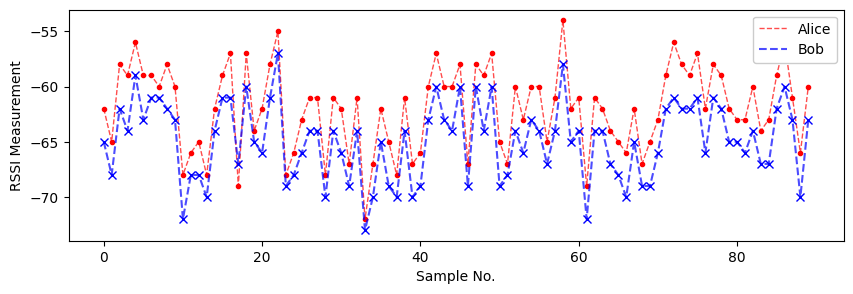

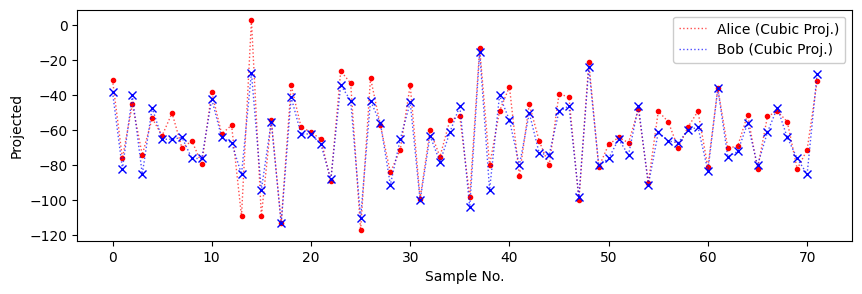

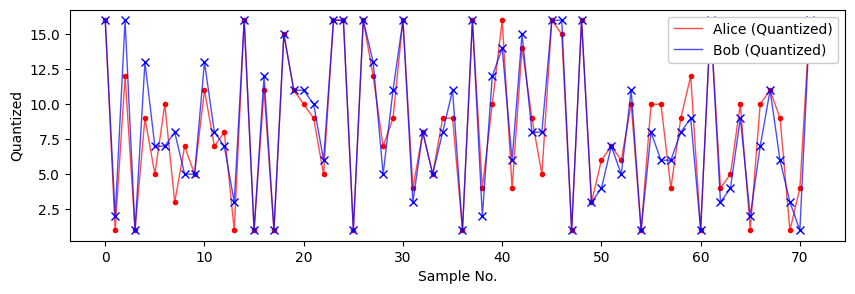

In [150]:
samples=[[-68, -68], [-58, -58], [-62, -62], [-64, -63], [-57, -56], [-64, -64], [-60, -58], [-62, -59], [-56, -56], [-56, -56], [-60, -58], [-56, -59], [-64, -63], [-52, -54], [-54, -45], [-47, -57], [-58, -60], [-62, -63], [-56, -56], [-47, -48], [-58, -61], [-54, -46], [-44, -45], [-58, -59], [-57, -58], [-47, -48], [-54, -55], [-58, -60], [-61, -63], [-62, -63], [-66, -67], [-58, -59], [-60, -64], [-62, -63], [-59, -59], [-58, -59], [-62, -63], [-59, -62], [-64, -66], [-56, -57], [-60, -63], [-60, -62], [-57, -58], [-57, -59], [-60, -61], [-61, -62], [-56, -57], [-58, -61], [-56, -58], [-59, -61], [-68, -70], [-58, -57], [-64, -65], [-59, -61], [-55, -58], [-55, -57], [-65, -63], [-56, -57], [-46, -46], [-48, -57], [-61, -63], [-61, -62], [-62, -63], [-68, -70], [-56, -49], [-58, -57], [-44, -46], [-59, -63], [-42, -51], [-53, -54], [-57, -57], [-65, -66], [-57, -59], [-55, -58], [-56, -58], [-69, -68], [-61, -62], [-61, -62], [-66, -63], [-58, -61], [-60, -60], [-58, -61], [-67, -67], [-62, -64], [-65, -67], [-61, -60], [-60, -62], [-62, -62], [-56, -57], [-57, -58], [-60, -62], [-58, -61], [-58, -58], [-55, -55], [-60, -61], [-58, -59]]
#[[-56, -55], [-58, -56], [-61, -61], [-55, -47], [-59, -59], [-57, -58], [-56, -53], [-54, -55], [-53, -52], [-61, -60], [-57, -56], [-57, -55], [-45, -43], [-55, -56], [-56, -55], [-51, -43], [-54, -46], [-44, -44], [-55, -55], [-45, -52], [-45, -44], [-53, -46], [-56, -56], [-59, -59], [-60, -58], [-58, -57], [-58, -57], [-67, -64], [-56, -56], [-66, -63], [-59, -58], [-62, -63], [-54, -53], [-62, -65], [-58, -58], [-60, -58], [-56, -57], [-68, -68], [-59, -59], [-56, -56], [-60, -60], [-61, -64], [-61, -62], [-60, -62], [-60, -61], [-59, -59], [-63, -65], [-65, -68], [-55, -58], [-68, -66], [-56, -56], [-57, -60], [-58, -61], [-64, -68], [-62, -64], [-55, -56], [-52, -56], [-57, -59], [-57, -59], [-55, -55], [-53, -56], [-54, -56], [-61, -62], [-62, -64], [-55, -58], [-66, -66], [-63, -63], [-57, -58], [-57, -57], [-58, -58], [-60, -63], [-47, -56], [-57, -60], [-44, -46], [-55, -56], [-64, -69], [-55, -57], [-55, -56], [-60, -61], [-60, -60], [-59, -60], [-61, -61], [-70, -68], [-68, -73], [-61, -63], [-64, -63], [-59, -58], [-60, -59], [-66, -71], [-62, -62], [-61, -62], [-56, -57], [-56, -58], [-52, -47], [-63, -63], [-57, -60], [-58, -61]]
#[[-45, -44], [-43, -42], [-54, -54], [-60, -60], [-55, -55], [-64, -63], [-56, -55], [-53, -44], [-43, -42], [-51, -45], [-45, -47], [-56, -57], [-56, -57], [-43, -43], [-58, -58], [-52, -46], [-52, -45], [-44, -45], [-58, -60], [-62, -64], [-61, -62], [-57, -58], [-69, -70], [-61, -62], [-59, -60], [-57, -59], [-66, -67], [-59, -60], [-47, -48], [-60, -61], [-59, -61], [-61, -63], [-58, -58], [-58, -59], [-57, -57], [-64, -67], [-64, -64], [-62, -63], [-57, -59], [-63, -63], [-58, -58], [-59, -62], [-61, -60], [-61, -66], [-57, -58], [-61, -59], [-46, -55], [-60, -61], [-59, -60], [-56, -59], [-61, -60], [-43, -54], [-52, -54], [-56, -58], [-53, -55], [-56, -57], [-57, -59], [-45, -46], [-57, -59], [-57, -58], [-58, -61], [-52, -53], [-48, -55], [-53, -56], [-59, -62], [-59, -61], [-57, -61], [-62, -61], [-60, -65], [-73, -66], [-59, -58], [-57, -60], [-64, -67], [-63, -66], [-55, -56], [-56, -58], [-65, -66], [-61, -60], [-67, -69], [-65, -66], [-59, -60], [-60, -61], [-55, -49], [-64, -65], [-56, -57], [-65, -67], [-59, -60], [-56, -46], [-62, -64], [-57, -59], [-55, -56], [-58, -58], [-47, -56]]
#[[-68, -68], [-58, -58], [-62, -62], [-64, -63], [-57, -56], [-64, -64], [-60, -58], [-62, -59], [-56, -56], [-56, -56], [-60, -58], [-56, -59], [-64, -63], [-52, -54], [-54, -45], [-47, -57], [-58, -60], [-62, -63], [-56, -56], [-47, -48], [-58, -61], [-54, -46], [-44, -45], [-58, -59], [-57, -58], [-47, -48], [-54, -55], [-58, -60], [-61, -63], [-62, -63], [-66, -67], [-58, -59], [-60, -64], [-62, -63], [-59, -59], [-58, -59], [-62, -63], [-59, -62], [-64, -66], [-56, -57], [-60, -63], [-60, -62], [-57, -58], [-57, -59], [-60, -61], [-61, -62], [-56, -57], [-58, -61], [-56, -58], [-59, -61], [-68, -70], [-58, -57], [-64, -65], [-59, -61], [-55, -58], [-55, -57], [-65, -63], [-56, -57], [-46, -46], [-48, -57], [-61, -63], [-61, -62], [-62, -63], [-68, -70], [-56, -49], [-58, -57], [-44, -46], [-59, -63], [-42, -51], [-53, -54], [-57, -57], [-65, -66], [-57, -59], [-55, -58], [-56, -58], [-69, -68], [-61, -62], [-61, -62], [-66, -63], [-58, -61], [-60, -60], [-58, -61], [-67, -67], [-62, -64], [-65, -67], [-61, -60], [-60, -62], [-62, -62], [-56, -57], [-57, -58], [-60, -62], [-58, -61], [-58, -58], [-55, -55], [-60, -61], [-58, -59]]

#### EXTRA TESTS
samples=[[-62, -65], [-65, -68], [-58, -62], [-59, -64], [-56, -59], [-59, -63], [-59, -61], [-60, -61], [-58, -62], [-60, -63], [-68, -72], [-66, -68], [-65, -68], [-68, -70], [-62, -64], [-59, -61], [-57, -61], [-69, -67], [-57, -60], [-64, -65], [-62, -66], [-58, -61], [-55, -57], [-68, -69], [-66, -68], [-63, -66], [-61, -64], [-61, -64], [-68, -70], [-61, -64], [-62, -66], [-67, -69], [-61, -64], [-72, -73], [-67, -70], [-62, -65], [-65, -69], [-68, -70], [-61, -64], [-67, -70], [-66, -69], [-60, -63], [-57, -60], [-60, -63], [-60, -64], [-58, -60], [-67, -69], [-58, -60], [-59, -64], [-57, -60], [-65, -69], [-67, -68], [-60, -64], [-63, -66], [-60, -63], [-60, -64], [-65, -67], [-61, -64], [-54, -58], [-62, -65], [-61, -64], [-69, -72], [-61, -64], [-62, -64], [-64, -67], [-65, -68], [-66, -70], [-62, -65], [-67, -69], [-65, -69], [-63, -66], [-59, -62], [-56, -61], [-58, -62], [-59, -62], [-57, -61], [-62, -66], [-58, -61], [-59, -62], [-62, -65], [-63, -65], [-63, -66], [-60, -64], [-64, -67], [-63, -67], [-59, -62], [-56, -60], [-61, -63], [-66, -70], [-60, -63], [-72, -73], [-67, -69], [-64, -67], [-60, -63], [-62, -64], [-60, -62], [-61, -65], [-72, -73], [-66, -69]]

cubic_A_all = []
cubic_B_all = []

quant_A_all = []
quant_B_all = []

window = 10
# print(len(samples))
samples = samples[:(int(len(samples)/window)*window)] ## To assert even division based on window 
# print(len(samples))

for i in range(0, len(samples)-window+1, window):
    alice = [x[0] for x in samples][i:i+window]
    bob = [x[1] for x in samples][i:i+window]
    #print(alice, bob)

    c_A = spline_projection(alice)
    c_B = spline_projection(bob)
    cubic_A_all.append(c_A)
    cubic_B_all.append(c_B)
    print("Projected: ", c_A, "\n", c_B)

    # quantization
    q_A = quantization_m(c_A, (len(c_A)*2))
    q_B = quantization_m(c_B, (len(c_B)*2))
    quant_A_all.append(q_A)
    quant_B_all.append(q_B)
    print("Quantized: ", q_A, "\n", q_B)

    # Alice - JS encoding
    alice_coeffs = poly_coeff_from_roots(q_A)        #[:t+1]
    t = int(len(alice_coeffs)/2) # - 1               Number of Coefficients sent ################################################################### 
    #print(poly_coeff_from_roots(q_A), alice_coeffs)
    print("Alice Sent Coeffs.: ", alice_coeffs[:t+1]) # t+1 -> to include 1

    # Bob - JS decoding
    # q_B _> quantized vals at bob
    coeffs, corr_seq = get_coeff_list(c=alice_coeffs[:t+1], w=q_B, t=t, v=2) # v is variations inside the decoder
    print("Bob Found Coeffs.:", coeffs) 

    q_A = sorted(q_A)
    corr_seq = sorted(corr_seq)
    random.Random(4).shuffle(q_A)
    random.Random(4).shuffle(corr_seq)
    print("Alice Held Seq.: ", q_A )
    print("Bob Found Seq.:", corr_seq ) 
    print("-------------------------------")

alice = [x[0] for x in samples]
bob = [x[1] for x in samples]
#################################################################
plt.figure(figsize=(10, 3))
plt.plot(alice, 'r--', label="Alice", linewidth=1, alpha=0.7)
plt.plot(alice, 'r.')
plt.plot(bob, 'b--', label="Bob", alpha=0.7)
plt.plot(bob, 'bx')
plt.xlabel("Sample No.")
plt.ylabel("RSSI Measurement")
plt.legend(framealpha=1, loc="upper right")
plt.show()
#################################################################

#################################################################
plt.figure(figsize=(10, 3))
plt.plot(np.array(cubic_A_all).flatten(), 'r:', label="Alice (Cubic Proj.)", linewidth=1, alpha=0.7)
plt.plot(np.array(cubic_A_all).flatten(), 'r.')
plt.plot(np.array(cubic_B_all).flatten(), 'b:', label="Bob (Cubic Proj.)", linewidth=1, alpha=0.7)
plt.plot(np.array(cubic_B_all).flatten(), 'bx')
plt.xlabel("Sample No.")
plt.ylabel("Projected")
plt.legend(framealpha=1, loc="upper right")
plt.show()
#################################################################

#################################################################
# print(quant_A_all)
# print(quant_B_all)
plt.figure(figsize=(10, 3))
plt.plot(np.array(quant_A_all).flatten(), 'r-', label="Alice (Quantized)", linewidth=1, alpha=0.7)
plt.plot(np.array(quant_A_all).flatten(), 'r.')
plt.plot(np.array(quant_B_all).flatten(), 'b-', label="Bob (Quantized)", linewidth=1, alpha=0.7)
plt.plot(np.array(quant_B_all).flatten(), 'bx')

plt.xlabel("Sample No.")
plt.ylabel("Quantized")
plt.legend(framealpha=1, loc="upper right")
plt.show()
#################################################################

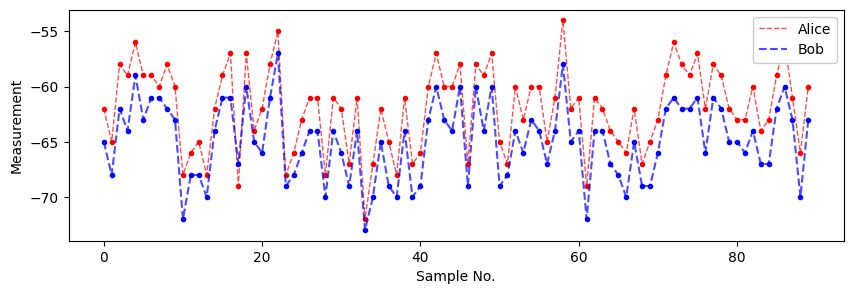

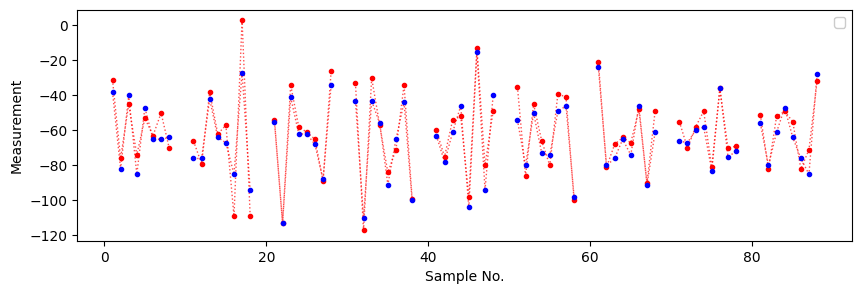

In [151]:
#################################################################
plt.figure(figsize=(10, 3))
plt.plot(alice, 'r--', label="Alice", linewidth=1, alpha=0.7)
plt.plot(alice, 'r.')
plt.plot(bob, 'b--', label="Bob", alpha=0.7)
plt.plot(bob, 'b.')
plt.xlabel("Sample No.")
plt.ylabel("Measurement")
plt.legend(framealpha=1, loc="upper right")
plt.show()
#################################################################

plt.figure(figsize=(10, 3))

#################################################################
## For showing the corresponding sample to projected+quantized
## ALICE
j = 1 ### 1
for c_i in cubic_A_all:
    c_a_x = []

    
    for i in range(len(c_i)):
        c_a_x.append(j+(i))
    j += 10

    if(j==1):
        plt.plot(c_a_x, c_i, 'r:', label="Alice (Quantized)", linewidth=1, alpha=0.7)
    else:
        plt.plot(c_a_x, c_i, 'r:', linewidth=1, alpha=0.7)
    plt.plot(c_a_x, c_i, 'r.')

# For showing the corresponding sample to projected+quantized
## BOB
j = 1 # 1
for c_i in cubic_B_all:
    c_b_x = []

    ## For showing the corresponding sample to projected+quantized
    for i in range(len(c_i)):
        c_b_x.append(j+(i))
    j += 10

    if(j==1):
        plt.plot(c_b_x, c_i, 'r:', label="Bob (Quantized)", linewidth=1, alpha=0.7)
    else:
        plt.plot(c_b_x, c_i, 'r:', linewidth=1, alpha=0.7)
    plt.plot(c_b_x, c_i, 'b.')
#################################################################


##################################################################################################################################
### Alternative plot to above
# # ALICE
# plt.plot(np.array(cubic_A_all).flatten(), 'r.', label="Alice (Projected)")
# plt.plot(np.array(cubic_A_all).flatten(), 'r:')

# # BOB
# plt.plot(np.array(cubic_B_all).flatten(), 'b.', label="Bob (Projected)")
# plt.plot(np.array(cubic_B_all).flatten(), 'b:')
##################################################################################################################################


plt.xlabel("Sample No.")
plt.ylabel("Measurement")
plt.legend(framealpha=1, loc="upper right")
plt.show()

---

### PCC Tests:

In [152]:
import numpy as np
def pearson_corr_2d(list1, list2):
    i = 0
    corr_list = []
    for l1, l2 in zip(list1, list2):
        i+=1
        #print(l1, l2)
        xs = np.array(l1) #(list1)
        ys = np.array(l2) #(list2)

        _x = sum(xs) / len(xs)
        _y = sum(ys) / len(ys)
        
        summation = sum((x - _x) * (y - _y) for x, y in zip(xs, ys))# / len(list1)

        div_x = np.sum((xs-_x)**2)      #(sum([(x-_x)**2 for x in xs]))
        div_y = np.sum((ys-_y)**2)      #(sum([(y-_y)**2 for y in ys]))

        divisor = (div_x**0.5 * div_y**0.5)
        if(divisor == 0):
            pearson_correlation_coeff = 0.0
        else:
            pearson_correlation_coeff = summation/divisor
        #PCC at step {i} 
        corr_list.append(pearson_correlation_coeff)
        #print(f"& {pearson_correlation_coeff:.4f}") 
    return corr_list

def pearson_corr(list1, list2):
    xs = np.array(list1)
    ys = np.array(list2)

    _x = sum(xs) / len(xs)
    _y = sum(ys) / len(ys)
    
    summation = sum((x - _x) * (y - _y) for x, y in zip(xs, ys))# / len(list1)

    div_x = np.sum((xs-_x)**2)      #(sum([(x-_x)**2 for x in xs]))
    div_y = np.sum((ys-_y)**2)      #(sum([(y-_y)**2 for y in ys]))

    divisor = (div_x**0.5 * div_y**0.5)
    if(divisor == 0):
        pearson_correlation_coeff = 0.0
    else:
        pearson_correlation_coeff = summation/divisor
    #print(f"& {pearson_correlation_coeff:.4f}")
    #print(f"PCC - Formula result: {pearson_correlation_coeff}") 
    return pearson_correlation_coeff
    

print(pearson_corr(alice, bob))
print()
print(pearson_corr(np.array(cubic_A_all).flatten(), np.array(cubic_B_all).flatten()))
print()
print(pearson_corr(np.array(quant_A_all).flatten(), np.array(quant_B_all).flatten()))

print()
print()
pcc_cubic = pearson_corr_2d(np.array(cubic_A_all), np.array(cubic_B_all))
pcc_quant = pearson_corr_2d(np.array(quant_A_all), np.array(quant_B_all))
pcc_list = []
for p,q in zip(pcc_cubic, pcc_quant):
    pcc_list.append(f" & {p:.4f} & {q:.4f}")
print()




0.9623394830561853

0.94540339867699

0.9446772843546857





In [153]:
pcc_ab = []
for i in range(0, len(samples)-window+1, window):
    alice_step = [x[0] for x in samples][i:i+window]
    bob_step   = [x[1] for x in samples][i:i+window]
    pcc_ab.append(pearson_corr(alice_step, bob_step))
#print(len(pcc_ab))
#print(len(pcc_list))
for i in range(len(pcc_ab)):
    pcc_list[i] = f"{i+1} & {pcc_ab[i]:.4f}" + " " + pcc_list[i] + " \\\\ \hline"
    print(pcc_list[i])

1 & 0.8946  & 0.8906 & 0.8896 \\ \hline
2 & 0.9255  & 0.9646 & 0.9616 \\ \hline
3 & 0.9806  & 0.9975 & 0.9942 \\ \hline
4 & 0.9777  & 0.9828 & 0.9826 \\ \hline
5 & 0.9639  & 0.9747 & 0.9676 \\ \hline
6 & 0.9705  & 0.9648 & 0.9653 \\ \hline
7 & 0.9729  & 0.9739 & 0.9752 \\ \hline
8 & 0.9547  & 0.9479 & 0.9284 \\ \hline
9 & 0.9629  & 0.9207 & 0.9291 \\ \hline


___

## Additional Evaluations

### Bit Entropy (functions)


$$ H(X) = -p \log_2(p) - (1 - p) \log_2(1 - p) $$

where:
- $H(X)$ is the entropy of the binary variable \( X \).
- $p$ is the probability that $X = 1$.
- $1 - p$ is the probability that $X = 0$.
- The logarithm is base 2 because we're measuring the entropy in bits.

### Interpretation
- **Maximum Entropy (1 bit)**: When $p = 0.5$, the binary variable is completely random, with equal probabilities for 0 and 1. The entropy is 1 bit, indicating maximum unpredictability.
- **Minimum Entropy (0 bits)**: When $p = 0$ or $p = 1$, the binary variable is entirely predictable (always 0 or always 1). The entropy is 0 bits, indicating no randomness.


In [164]:
def int_arr_to_bin_seq(array):
    array = [x-1 for x in array] #### ADDITIONAL STEP SINCE QUANTIZATION GOES TO 1 to 16 instead of 0 to 15
    binary_sequence = ''.join(format(num, '04b') for num in array) # 4 bits per number
    return binary_sequence

def bit_entropy(p):
    if p == 0 or p == 1:
        return 0
    return -p * math.log2(p) - (1 - p) * math.log2(1 - p)

def entropy_from_sequence(binary_sequence):
    length = len(binary_sequence)
    count_ones = binary_sequence.count('1')
    p = count_ones / length
    # print(p)
    entropy = bit_entropy(p)
    return entropy #,p

### Bit Disagreement Rate 
(post reconciliation - changing bob sequence to recon. numbers)

$$ \text{BDR} = \frac{1}{N} \sum_{i=1}^{N} count(x_i \neq y_i) $$

where:
-  $N$ is the length of the binary sequences.
-  $x_i$ and  $y_i$  are the bits at position $i$ in the two sequences $x$ and $y$, respectively.
- $count$  is an indicator function that equals 1 if the condition inside is true and 0 otherwise.

In [165]:
def bit_disagreement_rate(seq1, seq2):
    if len(seq1) != len(seq2):
        raise ValueError("Sequences must be of the same length")
    disagreement_count = sum(1 for bit1, bit2 in zip(seq1, seq2) if bit1 != bit2)
    bdr = disagreement_count / len(seq1)
    return bdr

# seq1 = '100001101011100000101011101001110101'
# seq2 = '111001110101110101110101110101110101'

# bdr = bit_disagreement_rate(seq1, seq2)
# print(bdr)

### Key Generation Rate

KGR = Reconciled Bits / Time

## Phase testing

In [172]:
sample_dict = {
    "Static": [
                [[-46, -46], [-45, -46], [-46, -46], [-46, -47], [-46, -46], [-46, -47], [-46, -47], [-48, -48], [-46, -47], [-46, -46], [-46, -46], [-46, -46], [-46, -46], [-46, -47], [-46, -47], [-46, -47], [-46, -46], [-46, -46], [-46, -47], [-46, -47], [-46, -47], [-46, -47], [-46, -47], [-46, -47], [-46, -47], [-47, -48], [-46, -47], [-46, -47], [-46, -47], [-46, -47], [-46, -47], [-47, -47], [-46, -47], [-46, -47], [-46, -47], [-46, -47], [-46, -47], [-43, -46], [-46, -46], [-46, -47], [-46, -47], [-46, -47], [-46, -47], [-46, -46], [-46, -47], [-46, -47], [-47, -48], [-46, -46], [-46, -47], [-46, -47], [-46, -47], [-46, -46], [-46, -47], [-46, -47], [-46, -47], [-46, -45], [-46, -47], [-46, -48], [-47, -48], [-46, -47], [-47, -47], [-47, -48], [-44, -47], [-47, -47], [-47, -47], [-47, -47], [-47, -49], [-47, -47], [-47, -47], [-47, -47], [-47, -48], [-47, -48], [-47, -47], [-47, -47], [-47, -47], [-47, -47], [-43, -48], [-46, -47], [-44, -47], [-46, -47], [-46, -47], [-47, -47], [-46, -47], [-47, -48], [-46, -47], [-47, -47], [-46, -47], [-47, -47], [-46, -46], [-47, -47], [-46, -48], [-46, -46], [-47, -48], [-46, -48], [-46, -48], [-47, -48], [-47, -47], [-46, -48], [-47, -47], [-47, -47], [-47, -47]],
                #[[-48, -50], [-50, -51], [-49, -51], [-49, -52], [-50, -52], [-50, -52], [-49, -52], [-51, -52], [-49, -52], [-50, -51], [-51, -52], [-51, -52], [-51, -51], [-50, -52], [-50, -51], [-51, -52], [-51, -52], [-51, -53], [-51, -51], [-51, -53], [-51, -52], [-51, -53], [-51, -53], [-52, -52], [-50, -52], [-51, -52], [-50, -52], [-50, -52], [-50, -52], [-50, -53], [-50, -51], [-49, -52], [-50, -52], [-50, -53], [-51, -52], [-51, -52], [-51, -53], [-50, -53], [-52, -52], [-51, -52], [-52, -52], [-51, -53], [-50, -52], [-51, -52], [-50, -51], [-50, -53], [-51, -52], [-51, -52], [-51, -53], [-51, -52], [-51, -53], [-51, -51], [-50, -51], [-50, -52], [-51, -52], [-51, -52], [-51, -51], [-51, -52], [-50, -52], [-50, -52], [-49, -52], [-50, -52], [-49, -52], [-50, -53], [-49, -52], [-51, -51], [-51, -52], [-51, -53], [-50, -53], [-51, -51], [-52, -53], [-52, -53], [-52, -53], [-50, -53], [-51, -52], [-52, -52], [-51, -52], [-51, -53], [-51, -53], [-51, -53], [-51, -52], [-52, -53], [-51, -52], [-51, -53], [-51, -53], [-51, -53], [-50, -52], [-51, -51], [-51, -52], [-51, -52], [-50, -53], [-51, -53], [-50, -52], [-51, -52], [-50, -51], [-51, -52], [-51, -52], [-51, -53], [-51, -53], [-51, -52], [-51, -53]],
                #[[-49, -50], [-48, -51], [-48, -50], [-49, -50], [-48, -50], [-49, -50], [-47, -51], [-49, -51], [-50, -50], [-49, -51], [-49, -51], [-49, -51], [-49, -51], [-50, -51], [-51, -51], [-50, -51], [-50, -51], [-50, -52], [-49, -51], [-49, -50], [-49, -50], [-49, -51], [-50, -51], [-50, -52], [-50, -52], [-50, -51], [-51, -52], [-51, -51], [-50, -51], [-49, -51], [-50, -51], [-50, -50], [-49, -52], [-50, -50], [-50, -51], [-50, -50], [-50, -51], [-50, -50], [-49, -51], [-50, -51], [-50, -51], [-50, -51], [-49, -51], [-50, -51], [-49, -51], [-50, -50], [-50, -51], [-50, -51], [-50, -51], [-49, -52], [-50, -50], [-50, -51], [-50, -50], [-49, -49], [-50, -52], [-49, -51], [-49, -51], [-50, -52], [-49, -52], [-48, -51], [-49, -50], [-49, -51], [-50, -50], [-49, -51], [-49, -52], [-50, -51], [-49, -52], [-49, -51], [-49, -50], [-49, -50], [-49, -50], [-49, -49], [-49, -51], [-48, -49], [-49, -50], [-49, -50], [-49, -51], [-49, -51], [-50, -50], [-50, -50], [-50, -51], [-50, -51], [-50, -51], [-50, -52], [-50, -51], [-50, -52], [-50, -50], [-49, -52], [-49, -51], [-50, -50], [-50, -52], [-50, -51], [-49, -51], [-49, -51], [-50, -51], [-49, -51], [-50, -51], [-49, -51], [-49, -52], [-50, -51], [-50, -51]]
    ],
    "Low-motion": [
                [[-57, -57], [-57, -57], [-54, -53], [-53, -54], [-54, -53], [-56, -57], [-56, -56], [-57, -57], [-60, -59], [-64, -64], [-62, -61], [-61, -61], [-61, -60], [-63, -63], [-64, -64], [-63, -63], [-65, -65], [-67, -67], [-68, -68], [-66, -66], [-65, -65], [-67, -67], [-64, -64], [-62, -63], [-61, -61], [-61, -61], [-62, -61], [-63, -62], [-66, -66], [-64, -64], [-60, -60], [-59, -57], [-61, -61], [-64, -63], [-61, -60], [-61, -61], [-59, -59], [-53, -54], [-55, -57], [-57, -57], [-57, -56], [-57, -57], [-56, -54], [-57, -55], [-58, -57], [-53, -53], [-57, -57], [-56, -56], [-55, -54], [-54, -52], [-53, -53], [-53, -53], [-54, -54], [-56, -54], [-56, -56], [-57, -56], [-57, -57], [-56, -57], [-57, -57], [-59, -57], [-59, -59], [-59, -59], [-60, -59], [-61, -61], [-64, -64], [-65, -64], [-61, -60], [-60, -59], [-60, -60], [-59, -57], [-59, -57], [-53, -53], [-53, -53], [-53, -53], [-51, -50], [-53, -51], [-52, -51], [-51, -50], [-50, -50], [-48, -48], [-47, -47], [-47, -47], [-47, -46], [-46, -45], [-46, -45], [-46, -45], [-46, -45], [-45, -45], [-45, -45], [-45, -44], [-45, -44], [-45, -41], [-44, -41], [-44, -41], [-44, -41], [-44, -40], [-44, -40], [-44, -43], [-43, -40], [-43, -43], [-43, -40]],
                [[-50, -50], [-50, -50], [-50, -51], [-50, -51], [-50, -51], [-49, -51], [-47, -51], [-50, -51], [-50, -51], [-51, -52], [-52, -52], [-52, -53], [-52, -52], [-52, -52], [-52, -53], [-51, -53], [-52, -53], [-53, -53], [-53, -53], [-53, -53], [-56, -53], [-54, -55], [-56, -56], [-54, -56], [-53, -56], [-55, -56], [-56, -56], [-55, -57], [-56, -56], [-55, -56], [-56, -56], [-56, -56], [-56, -57], [-56, -56], [-57, -56], [-57, -56], [-57, -57], [-57, -57], [-57, -56], [-57, -58], [-57, -56], [-56, -56], [-57, -56], [-57, -54], [-57, -56], [-57, -56], [-57, -56], [-54, -56], [-57, -56], [-56, -57], [-57, -56], [-56, -57], [-56, -57], [-56, -56], [-57, -57], [-57, -57], [-57, -58], [-59, -57], [-59, -59], [-59, -60], [-60, -58], [-60, -60], [-60, -60], [-59, -59], [-59, -60], [-60, -60], [-60, -60], [-60, -59], [-59, -60], [-59, -60], [-59, -60], [-60, -59], [-59, -60], [-60, -60], [-58, -60], [-59, -59], [-59, -58], [-59, -58], [-59, -59], [-59, -58], [-59, -59], [-59, -60], [-60, -60], [-60, -59], [-59, -60], [-60, -60], [-60, -61], [-60, -61], [-61, -61], [-62, -61], [-61, -62], [-61, -62], [-61, -62], [-61, -61], [-61, -60], [-61, -61], [-60, -60], [-59, -60], [-59, -60], [-59, -59]],
                [[-51, -51], [-52, -51], [-52, -51], [-51, -52], [-52, -51], [-53, -51], [-52, -52], [-52, -51], [-53, -53], [-57, -54], [-56, -54], [-55, -54], [-56, -54], [-56, -56], [-58, -58], [-60, -58], [-63, -62], [-64, -63], [-66, -64], [-66, -65], [-66, -65], [-67, -65], [-66, -66], [-67, -65], [-67, -65], [-64, -63], [-62, -62], [-62, -62], [-60, -59], [-56, -56], [-53, -53], [-52, -51], [-52, -52], [-53, -53], [-51, -51], [-51, -50], [-51, -49], [-48, -49], [-48, -48], [-49, -47], [-48, -48], [-47, -48], [-49, -48], [-49, -48], [-48, -48], [-47, -47], [-47, -47], [-47, -47], [-48, -47], [-48, -48], [-49, -49], [-49, -48], [-48, -48], [-47, -48], [-47, -47], [-47, -47], [-49, -48], [-49, -49], [-50, -50], [-51, -51], [-52, -51], [-54, -53], [-56, -55], [-56, -56], [-56, -56], [-56, -53], [-54, -54], [-56, -54], [-53, -52], [-51, -52], [-52, -51], [-52, -51], [-51, -50], [-50, -50], [-49, -50], [-49, -49], [-49, -48], [-48, -49], [-47, -48], [-47, -47], [-47, -46], [-47, -46], [-47, -47], [-47, -46], [-46, -45], [-44, -46], [-46, -45], [-47, -45], [-47, -46], [-47, -45], [-47, -46], [-47, -46], [-48, -47], [-47, -46], [-47, -46], [-47, -46], [-48, -47], [-49, -47], [-50, -48], [-51, -50], [-52, -52]],
                [[-48, -47], [-47, -47], [-47, -47], [-47, -47], [-48, -47], [-47, -47], [-47, -47], [-47, -47], [-47, -47], [-47, -47], [-47, -47], [-47, -47], [-47, -47], [-48, -49], [-47, -48], [-48, -48], [-48, -48], [-48, -48], [-48, -48], [-49, -48], [-48, -48], [-48, -48], [-48, -48], [-48, -48], [-47, -48], [-49, -49], [-48, -48], [-48, -48], [-49, -48], [-49, -48], [-49, -48], [-48, -48], [-49, -49], [-49, -49], [-50, -49], [-50, -49], [-50, -50], [-50, -50], [-49, -49], [-50, -49], [-49, -49], [-49, -49], [-49, -49], [-49, -49], [-49, -49], [-49, -49], [-49, -49], [-48, -49], [-49, -49], [-49, -49], [-49, -49], [-48, -49], [-48, -49], [-48, -49], [-49, -49], [-48, -48], [-48, -48], [-48, -48], [-48, -48], [-48, -48], [-49, -48], [-48, -50], [-49, -49], [-48, -48], [-48, -48], [-48, -48], [-48, -48], [-48, -48], [-47, -48], [-48, -48], [-48, -48], [-48, -48], [-48, -48], [-47, -48], [-48, -48], [-49, -48], [-49, -49], [-48, -49], [-49, -49], [-47, -49], [-49, -49], [-49, -49], [-49, -49], [-49, -49], [-49, -49], [-49, -49], [-48, -49], [-49, -49], [-50, -49], [-49, -49], [-49, -49], [-49, -49], [-49, -49], [-50, -49], [-49, -49], [-49, -49], [-48, -50], [-49, -49], [-49, -48], [-49, -49]]
    ],
    "High-motion": [
                [[-62, -65], [-54, -51], [-61, -58], [-44, -51], [-56, -57], [-42, -50], [-42, -41], [-58, -57], [-55, -57], [-61, -60], [-58, -57], [-62, -59], [-56, -55], [-45, -52], [-46, -44], [-45, -52], [-52, -43], [-53, -53], [-43, -50], [-56, -57], [-55, -46], [-54, -53], [-62, -62], [-59, -60], [-53, -45], [-59, -57], [-56, -56], [-57, -58], [-62, -62], [-65, -63], [-58, -57], [-64, -63], [-57, -55], [-60, -60], [-66, -64], [-61, -59], [-57, -56], [-57, -57], [-59, -60], [-58, -57], [-63, -61], [-57, -56], [-58, -57], [-57, -57], [-56, -57], [-59, -59], [-47, -53], [-60, -60], [-66, -68], [-59, -61], [-47, -56], [-56, -59], [-53, -46], [-45, -47], [-43, -44], [-40, -41], [-61, -63], [-56, -59], [-66, -66], [-56, -58], [-60, -59], [-44, -53], [-43, -44], [-56, -56], [-44, -56], [-40, -41], [-56, -58], [-57, -61], [-44, -45], [-58, -59], [-60, -61], [-45, -55], [-61, -63], [-56, -58], [-58, -60], [-60, -60], [-62, -62], [-58, -59], [-57, -58], [-68, -69], [-58, -60], [-60, -60], [-60, -61], [-72, -70], [-62, -63], [-62, -64], [-62, -61], [-59, -59], [-62, -63], [-60, -61], [-69, -70], [-60, -61], [-63, -65], [-58, -56], [-64, -62], [-57, -58], [-56, -57]],
                [[-47, -47], [-47, -44], [-43, -45], [-42, -44], [-41, -40], [-46, -46], [-42, -44], [-48, -47], [-45, -42], [-45, -44], [-45, -45], [-46, -44], [-45, -44], [-46, -46], [-47, -48], [-49, -50], [-50, -51], [-51, -50], [-48, -47], [-51, -50], [-47, -47], [-44, -44], [-44, -41], [-44, -43], [-43, -40], [-39, -38], [-38, -38], [-48, -48], [-48, -48], [-37, -37], [-39, -39], [-46, -46], [-38, -38], [-37, -37], [-36, -36], [-38, -37], [-36, -37], [-50, -48], [-45, -45], [-44, -41], [-43, -41], [-39, -38], [-37, -37], [-44, -40], [-38, -37], [-45, -45], [-36, -36], [-35, -35], [-37, -36], [-52, -51], [-37, -38], [-37, -37], [-36, -35], [-46, -46], [-46, -46], [-50, -50], [-37, -37], [-33, -33], [-39, -44], [-47, -47], [-38, -37], [-34, -33], [-38, -38], [-45, -44], [-36, -35], [-46, -45], [-37, -37], [-37, -37], [-39, -38], [-53, -53], [-52, -52], [-47, -48], [-46, -47], [-51, -52], [-52, -52], [-38, -37], [-32, -32], [-34, -33], [-41, -39], [-45, -45], [-39, -38], [-34, -34], [-32, -31], [-28, -28], [-36, -37], [-47, -46], [-33, -32], [-31, -31], [-37, -37], [-35, -34], [-26, -26], [-28, -27], [-40, -41], [-31, -31], [-27, -27], [-35, -35], [-40, -42], [-38, -38], [-35, -35], [-42, -39], [-44, -42]],
                [[-29, -29], [-30, -29], [-31, -31], [-36, -35], [-37, -37], [-31, -31], [-29, -28], [-28, -28], [-31, -30], [-37, -36], [-45, -44], [-36, -34], [-37, -37], [-32, -31], [-28, -28], [-32, -32], [-46, -46], [-39, -36], [-34, -32], [-30, -29], [-33, -32], [-42, -38], [-50, -50], [-42, -39], [-43, -41], [-42, -40], [-45, -44], [-47, -48], [-39, -36], [-37, -36], [-41, -40], [-47, -46], [-46, -45], [-43, -42], [-43, -40], [-47, -47], [-46, -45], [-52, -51], [-49, -47], [-49, -48], [-43, -40], [-38, -38], [-40, -40], [-45, -44], [-49, -49], [-40, -39], [-44, -44], [-44, -41], [-49, -49], [-41, -40], [-37, -38], [-35, -34], [-44, -43], [-51, -51], [-36, -36], [-37, -37], [-44, -43], [-39, -38], [-38, -37], [-43, -40], [-37, -39], [-36, -35], [-39, -39], [-45, -44], [-44, -44], [-36, -35], [-45, -44], [-39, -38], [-36, -35], [-40, -39], [-38, -37], [-37, -37], [-36, -35], [-51, -51], [-52, -52], [-39, -41], [-40, -40], [-44, -43], [-46, -43], [-47, -46], [-52, -51], [-36, -35], [-38, -37], [-39, -38], [-40, -41], [-47, -47], [-43, -41], [-38, -37], [-44, -44], [-37, -37], [-40, -38], [-33, -32], [-32, -31], [-33, -32], [-37, -36], [-39, -38], [-49, -51], [-41, -40], [-36, -36], [-33, -32], [-44, -40]]
    ]
}

In [173]:
for k in sample_dict:
    print(k)
    for samples in sample_dict[k]:
        cubic_A_all = []
        cubic_B_all = []

        quant_A_all = []
        quant_B_all = []

        window = 10
        # print(len(samples))
        samples = samples[:(int(len(samples)/window)*window)] ## To assert even division based on window 
        # print(len(samples))

        ########################
        start_time = time.time()
        success_count = 0
        key_bits = ""
        cumulative_alice = ""
        cumulative_bob = ""
        ########################

        for i in range(0, len(samples)-window+1, window):
            alice = [x[0] for x in samples][i:i+window]
            bob = [x[1] for x in samples][i:i+window]
            #print(alice, bob)

            c_A = spline_projection(alice)
            c_B = spline_projection(bob)
            cubic_A_all.append(c_A)
            cubic_B_all.append(c_B)
            #print("Projected: ", c_A, "\n", c_B)

            # quantization
            q_A = quantization_m(c_A, (len(c_A)*2))
            q_B = quantization_m(c_B, (len(c_B)*2))
            quant_A_all.append(q_A)
            quant_B_all.append(q_B)
            #print("Quantized: ", q_A, "\n", q_B)

            # Alice - JS encoding
            alice_coeffs = poly_coeff_from_roots(q_A)        #[:t+1]
            t = int(len(alice_coeffs)/2) #- 1               # Number of Coefficients sent ################################################################### 
            #print(poly_coeff_from_roots(q_A), alice_coeffs)
            #print("Alice Sent Coeffs.: ", alice_coeffs[:t+1]) # t+1 -> to include 1

            # Bob - JS decoding
            # q_B _> quantized vals at bob
            coeffs, corr_seq = get_coeff_list(c=alice_coeffs[:t+1], w=q_B, t=t, v=1) # v is variations inside the decoder
            #print("Bob Found Coeffs.:", coeffs) 
            if(len(coeffs)==1):
                q_A = sorted(q_A)
                corr_seq = sorted(corr_seq)
                random.Random(123).shuffle(q_A)
                random.Random(123).shuffle(corr_seq)
                #print("Alice Held Seq.: ", q_A )
                #print("Bob Found Seq.:", corr_seq ) 
                #print("-------------------------------")
                #print(q_A==corr_seq)

                #if(q_A==corr_seq):
                success_count += 1
                key_bits = key_bits + int_arr_to_bin_seq(corr_seq)

                cumulative_alice = cumulative_alice + int_arr_to_bin_seq(q_A)  ## SHOULD BE SAME ON BOTH >>
                cumulative_bob   = cumulative_bob   + int_arr_to_bin_seq(corr_seq)
                    # print(key_bits)
            else:
                cumulative_alice = cumulative_alice + int_arr_to_bin_seq(q_A)  ## FAILED
                cumulative_bob   = cumulative_bob   + int_arr_to_bin_seq(q_B)
                #print(q_A) # cumulative_alice, 
                #print( q_B) # cumulative_bob,
        # 32 bits per successful recon.
        print("KGR:\t\t", (32*success_count)/(time.time()-start_time)) 
        print("Bit Entropy:\t", entropy_from_sequence(key_bits))
        print("BDR:\t\t", bit_disagreement_rate(cumulative_alice, cumulative_bob))
        

Static
KGR:		 25.968319738849704
Bit Entropy:	 0.9283620723948676
BDR:		 0.45
Low-motion
KGR:		 25.74445804811813
Bit Entropy:	 0.9971803988942642
BDR:		 0.303125
KGR:		 25.638892003651627
Bit Entropy:	 0.9283620723948676
BDR:		 0.428125
KGR:		 52.56391595662209
Bit Entropy:	 0.9971803988942642
BDR:		 0.434375
KGR:		 51.901874330527185
Bit Entropy:	 0.9971803988942642
BDR:		 0.3125
High-motion
KGR:		 84.85984674135707
Bit Entropy:	 1.0
BDR:		 0.2222222222222222
KGR:		 129.5544167684207
Bit Entropy:	 0.9995491108252483
BDR:		 0.140625
KGR:		 179.93330592109987
Bit Entropy:	 0.9985618875210815
BDR:		 0.071875


### COMPARISON 

#### Together

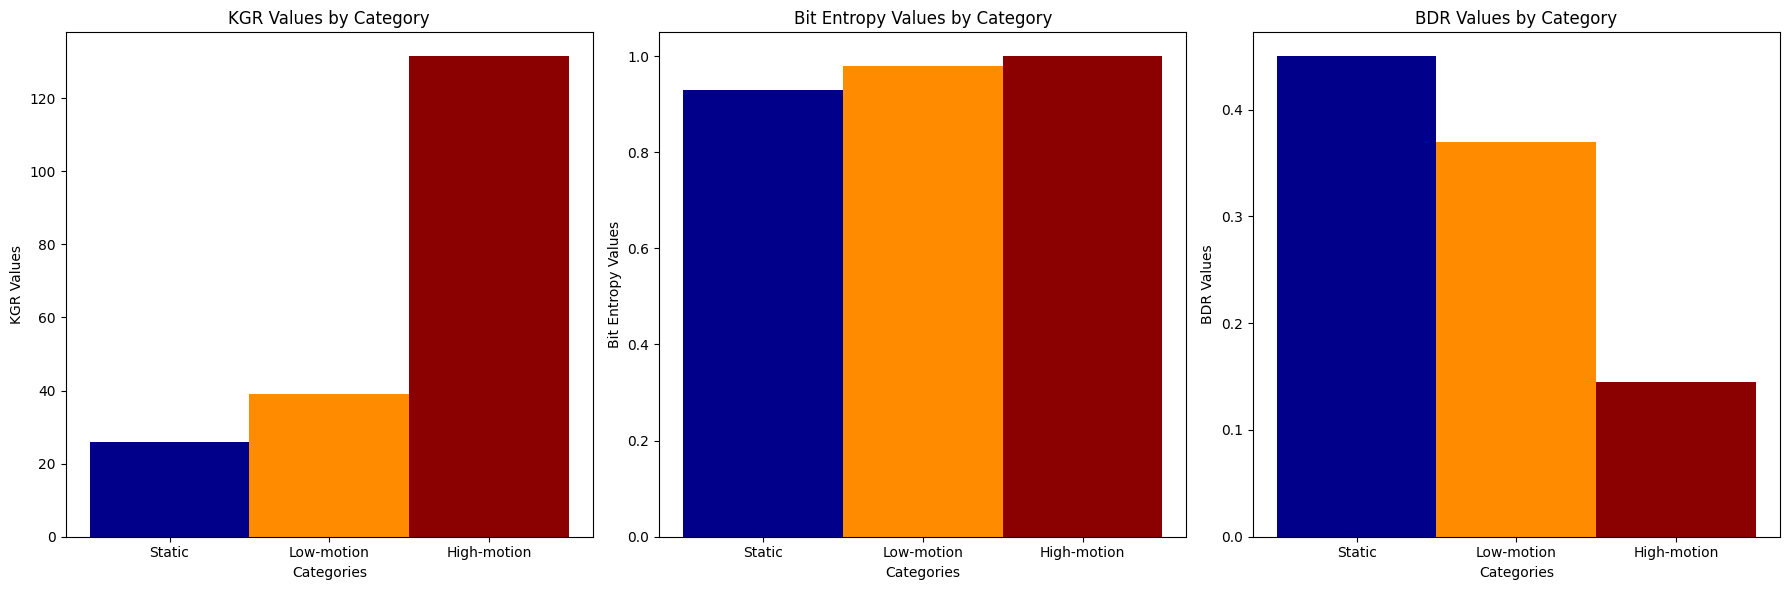

In [204]:
categories = ['Static', 'Low-motion', 'High-motion']
kgr_values = [
    25.968319738849704,  # Static
    np.mean([25.74445804811813, 25.638892003651627, 52.56391595662209, 51.901874330527185]),  # Low-motion
    np.mean([84.85984674135707, 129.5544167684207, 179.93330592109987])  # High-motion
]
bit_entropy_values = [
    0.9283620723948676,  # Static
    np.mean([0.9971803988942642, 0.9283620723948676, 0.9971803988942642, 0.9971803988942642]),  # Low-motion
    np.mean([1.0, 0.9995491108252483, 0.9985618875210815])  # High-motion
]
bdr_values = [
    0.45,  # Static
    np.mean([0.303125, 0.428125, 0.434375, 0.3125]),  # Low-motion
    np.mean([0.2222222222222222, 0.140625, 0.071875])  # High-motion
]

colors =['darkblue', 'darkorange', 'darkred']
indices = np.arange(len(categories))

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# KGR
axes[0].bar(indices, kgr_values, width=1.0, color=colors)
axes[0].set_xlabel('Categories')
axes[0].set_ylabel('KGR Values')
axes[0].set_title('KGR Values by Category')
axes[0].set_xticks(indices)
axes[0].set_xticklabels(categories)

# Bit Entropy
axes[1].bar(indices, bit_entropy_values, width=1.0, color=colors)
axes[1].set_xlabel('Categories')
axes[1].set_ylabel('Bit Entropy Values')
axes[1].set_title('Bit Entropy Values by Category')
axes[1].set_xticks(indices)
axes[1].set_xticklabels(categories)

# BDR
axes[2].bar(indices, bdr_values, width=1.0, color=colors)
axes[2].set_xlabel('Categories')
axes[2].set_ylabel('BDR Values')
axes[2].set_title('BDR Values by Category')
axes[2].set_xticks(indices)
axes[2].set_xticklabels(categories)

plt.tight_layout()
plt.show()


#### KGR

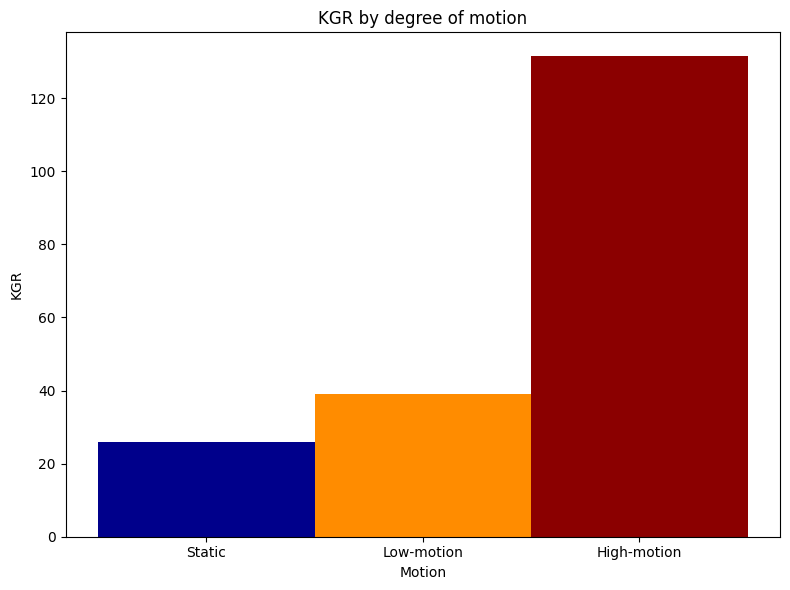

In [197]:
categories = ['Static', 'Low-motion', 'High-motion']
kgr_values = [
    25.968319738849704,  # Static
    np.mean([25.74445804811813, 25.638892003651627, 52.56391595662209, 51.901874330527185]),  # Low-motion
    np.mean([84.85984674135707, 129.5544167684207, 179.93330592109987])  # High-motion
]

indices = np.arange(len(categories))
colors = ['darkblue', 'darkorange', 'darkred']

fig, ax = plt.subplots(figsize=(8, 6))

bars = ax.bar(indices, kgr_values, width=1, color=colors)

ax.set_xlabel('Motion')
ax.set_ylabel('KGR')
ax.set_title('KGR by degree of motion')
ax.set_xticks(indices)
ax.set_xticklabels(categories)

plt.tight_layout()
plt.show()


#### BIT ENTROPY

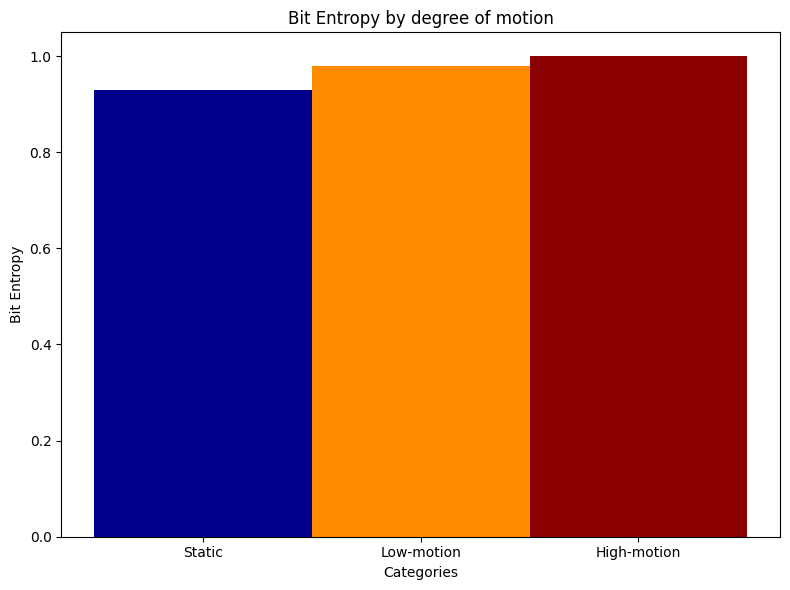

In [200]:
categories = ['Static', 'Low-motion', 'High-motion']
bit_entropy_values = [
    0.9283620723948676,  # Static
    np.mean([0.9971803988942642, 0.9283620723948676, 0.9971803988942642, 0.9971803988942642]),  # Low-motion
    np.mean([1.0, 0.9995491108252483, 0.9985618875210815])  # High-motion
]

colors = ['darkblue', 'darkorange', 'darkred']
indices = np.arange(len(categories))

fig, ax = plt.subplots(figsize=(8, 6))

bars = ax.bar(indices, bit_entropy_values, width=1.0, color=colors)

ax.set_xlabel('Categories')
ax.set_ylabel('Bit Entropy')
ax.set_title('Bit Entropy by degree of motion')
ax.set_xticks(indices)
ax.set_xticklabels(categories)

plt.tight_layout()
plt.show()


#### BDR

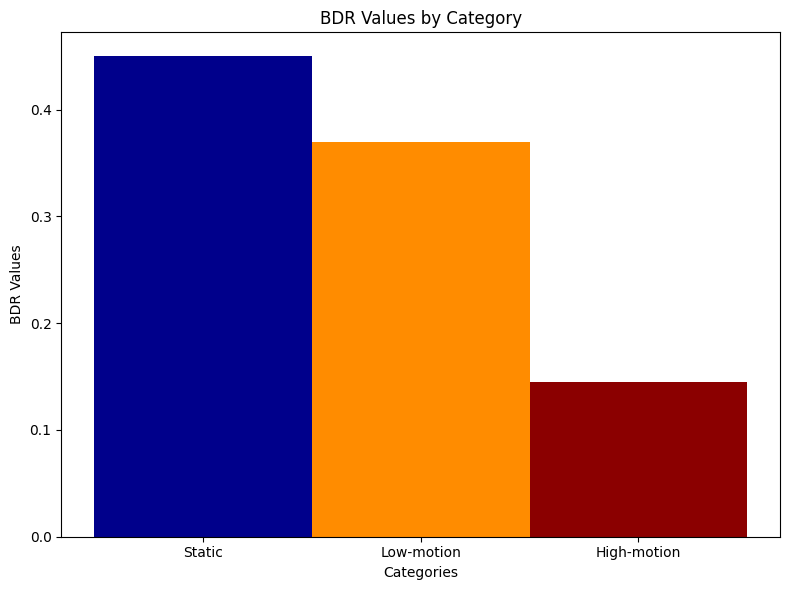

In [201]:
categories = ['Static', 'Low-motion', 'High-motion']
bdr_values = [
    0.45,  # Static
    np.mean([0.303125, 0.428125, 0.434375, 0.3125]),  # Low-motion
    np.mean([0.2222222222222222, 0.140625, 0.071875])  # High-motion
]

colors = ['darkblue', 'darkorange', 'darkred']

indices = np.arange(len(categories))
fig, ax = plt.subplots(figsize=(8, 6))

bars = ax.bar(indices, bdr_values, width=1.0, color=colors)

ax.set_xlabel('Categories')
ax.set_ylabel('BDR Values')
ax.set_title('BDR Values by Category')
ax.set_xticks(indices)
ax.set_xticklabels(categories)

plt.tight_layout()
plt.show()


In [177]:
# test = int_arr_to_bin_seq([2, 15, 13, 9, 16, 1, 4, 9])
# print(test, len(test))
# print(entropy_from_sequence(test)) 


In [176]:
# for num in [2, 15, 13, 9, 16, 1, 4, 9]:
#     print(format(num, "04b"))
#     print(time.time())

## END ##